In [63]:
import pandas as pd
%matplotlib inline

train = pd.read_csv("train.csv")
holdout = pd.read_csv("test.csv")

holdout.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [64]:
# %load functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [65]:
def clean_data(data):
    data = process_missing(data)
    data = process_age(data)
    data = process_fare(data)
    data = process_titles(data)
    data = process_cabin(data)
    dummy_cols = ["Age_categories", "Fare_categories",
                 "Title", "Cabin_type", "Sex"]
    for col in dummy_cols:
        data = create_dummies(data, col)
        
    return data




In [66]:
train = clean_data(train)

holdout = clean_data(holdout)

In [67]:
# Explore the two family size columns across survival

# SibSp - # of siblings / spouses aboard the Titanic
# Parch - # of parents / children aboard the Titanic

print(train["SibSp"].dtype)
print(train["Parch"].dtype)

print(train["SibSp"].describe())
print(train["Parch"].describe())

print("Number of Null Values for SibSp: ", train["SibSp"].isnull().sum())
print("Number of Null Values for Parch: ", train["Parch"].isnull().sum())

int64
int64
count    891.000000
mean       0.523008
std        1.102743
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        8.000000
Name: SibSp, dtype: float64
count    891.000000
mean       0.381594
std        0.806057
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        6.000000
Name: Parch, dtype: float64
Number of Null Values for SibSp:  0
Number of Null Values for Parch:  0


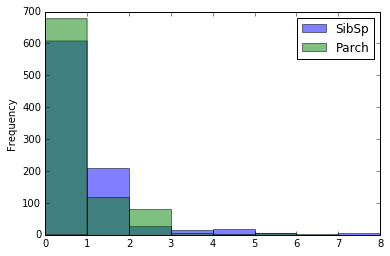

In [68]:
family_cols = ["SibSp", "Parch", "Survived"]
family_data = train[family_cols].copy()

family_data.drop("Survived",axis=1).plot.hist(alpha=0.5,bins=8)

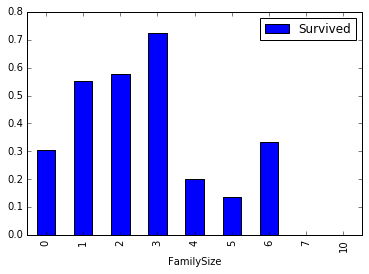

In [69]:
family_data["FamilySize"] = family_data["SibSp"] + family_data["Parch"]

fam_pivot = family_data.pivot_table(index="FamilySize",values="Survived")

fam_pivot.plot.bar()

## Findings - Family Size

It appears the majority of passengers had no family members aboard the titantic based on the frequency distribution of total family members. 

There appears to be a normal distribution of family size. Having a larger family (rather than zero family members) appears to have led to a higher chance of survival.

## Feature Engineering - Solo Passenger

We're going to add a new feature column, "isalone" to determine if passengers were alone or not, based on the number of siblings or parents they had, and add this as a feature to our model.


In [145]:
def is_passenger_alone(data):
    data["familysize"] = data["SibSp"] + data["Parch"]
    data["isalone"] = 0
    data.loc[data["familysize"]==0, "isalone"]=1
    data.drop(["familysize"],axis=1)
    return data

In [146]:
train = is_passenger_alone(train)
holdout = is_passenger_alone(holdout)

In [147]:
train["isalone"].value_counts()

1    537
0    354
Name: isalone, dtype: int64

In [155]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

def select_features(data):
    only_int_data = data.select_dtypes(include=["number"])
    only_int_data.dropna()
    
    all_X = only_int_data.drop(["PassengerId", "Survived"],axis=1)
    
    all_y = only_int_data["Survived"]
    rf = RandomForestClassifier(random_state=1)
    selector = RFECV(rf, cv=10)
    selector.fit(all_X, all_y)
    
    best_columns = list(all_X.columns[selector.support_])
    print("Best columns: \n{}\n".format(best_columns))
    return best_columns


In [ ]:
best_features = select_features(train)

## Using Dictionaries and GridSearchCV to optimize our model and feature selection workflow

We're going to use a dictionary of dictionaries and GridSearchCV to try different models and parameters to see which has the best results on our dataset

In [174]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

def select_model(data, features):
    all_X = data[features]
    all_y = data["Survived"]
    
    model_dict = [
        {
            "name": "LogisticRegression",
            "estimator": LogisticRegression(),
            "hyperparameters":
            {
                "solver":["newton-cg", "lbfgs", "liblinear"]
            }
        },
        {
            "name": "KNeighborsClassifier",
            "estimator": KNeighborsClassifier(),
            "hyperparameters": {
                "n_neighbors": range(1,20,2),
                "weights": ["distance", "uniform"],
                "algorithm": ["ball_tree", "kd_tree", "brute"],
                "p":[1,2]
            }
        },
        {
            "name":"RandomForestClassifier",
            "estimator": RandomForestClassifier(),
            "hyperparameters": {
                "n_estimators": [4,6,9],
                "criterion": ["entropy", "gini"],
                "max_depth": [2,5,10],
                "max_features": ["log2","sqrt"],
                "min_samples_leaf": [1,5,8],
                "min_samples_split": [2,3,5]
            }
        }
    ]
    
    for model in model_dict:
        print(model["name"])
        print("-"*len(model["name"]))
        grid = GridSearchCV(model["estimator"],
                            param_grid=model["hyperparameters"],
                            cv=10)
        grid.fit(all_X, all_y)
        model["best_params"] = grid.best_params_
        model["best_score"] = grid.best_score_
        model["best_model"] = grid.best_estimator_
        
        print("Best Score: {}.".format(model["best_score"]))
        print("Best Parameters: {}\n".format(model["best_params"]))
        
    return model_dict
        


In [176]:
best_model = select_model(train, best_features)

LogisticRegression
------------------
Best Score: .0.8181818181818182.
Best Parameters: {'solver': 'newton-cg'}

KNeighborsClassifier
--------------------
Best Score: .0.7800224466891134.
Best Parameters: {'weights': 'uniform', 'n_neighbors': 3, 'p': 1, 'algorithm': 'kd_tree'}

RandomForestClassifier
----------------------
Best Score: .0.8428731762065096.
Best Parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 9, 'criterion': 'entropy', 'min_samples_leaf': 1, 'max_features': 'log2'}



In [181]:
def save_submission_file(model, columns, filename="submission.csv"):
    model.fit(train[columns], train["Survived"])
    predictions = model.predict(holdout[columns])
    
    submission_ids = holdout["PassengerId"]
    
    submission_df = {
        "PassengerId": submission_ids,
        "Survived": predictions
    }
    
    submission = pd.DataFrame(submission_df)
    submission.to_csv(filename,index=False)
    

    

In [182]:
best_rf_model = best_model[2]["best_model"]

In [183]:
best_rf_model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features='log2', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            n_estimators=9, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [184]:
save_submission_file(best_rf_model, best_features, "submission.csv")